In [10]:
import tensorflow.compat.v1 as tf
import pandas as pd

In [58]:
census = pd.read_csv("0.csv",skiprows=1, header=None)

census.columns = ['age','workclass' , 'education', 'education_num', 'marital_status',
        'occupation', 'relationship', 'race', 'gender', 'capital_gain',
        'capital_loss', 'hours_per_week', 'native_country', 'income_bracket']

census.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [59]:
census['income_bracket'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [60]:
def label_fix(label):
    if label==' <=50K':
        return 0
    else:
        return 1
census['income_bracket'] = census['income_bracket'].apply(label_fix)
census['income_bracket'].unique()


array([0, 1])

In [61]:
from sklearn.model_selection import train_test_split
x_data = census.drop('income_bracket',axis=1)
y_labels = census['income_bracket']
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

In [62]:
age = tf.feature_column.numeric_column("age")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

In [63]:
gender = tf.feature_column.categorical_column_with_vocabulary_list("gender", ["Female", "Male"])

In [64]:
occupation = tf.feature_column.categorical_column_with_hash_bucket("occupation", hash_bucket_size=1000)
marital_status = tf.feature_column.categorical_column_with_hash_bucket("marital_status", hash_bucket_size=1000)
relationship = tf.feature_column.categorical_column_with_hash_bucket("relationship", hash_bucket_size=1000)
education = tf.feature_column.categorical_column_with_hash_bucket("education", hash_bucket_size=1000)
workclass = tf.feature_column.categorical_column_with_hash_bucket("workclass", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket("native_country", hash_bucket_size=1000)

In [65]:
feat_cols = [gender,occupation,marital_status,relationship,education,workclass,native_country, age,education_num,capital_gain,capital_loss,hours_per_week]

In [66]:
input_func=tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=100,num_epochs=None,shuffle=True)

In [67]:
model = tf.estimator.LinearClassifier(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8ftdy0ax', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [68]:
model.train(input_fn=input_func,steps = 100)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp8ftdy0ax/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 69.31472, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100...
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmp8ftdy0ax/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100...
INFO:tensorflow:Loss for final step: 298.05392.


In [70]:
pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=len(X_test),shuffle=False)
predictions = list(model.predict(input_fn=pred_fn))

final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

from sklearn.metrics import classification_report
print(classification_report(y_test,final_preds))

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8ftdy0ax/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7436
           1       0.63      0.57      0.60      2333

    accuracy                           0.82      9769
   macro avg       0.75      0.73      0.74      9769
weighted avg       0.81      0.82      0.81      9769



ROC AUC Score: 0.7328452689122346


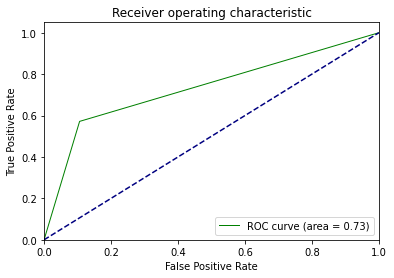

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,final_preds)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score: {}".format(roc_auc))
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()